In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, minmax_scale
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import sys 
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.utils import np_utils
import tensorflow as tf
#from keras.regularizers import L1L2
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.utils import shuffle
#from keras.callbacks import EarlyStopping
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from featurewiz import featurewiz
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectKBest, f_classif, chi2, RFE
from sklearn.feature_selection import mutual_info_classif
np.random.seed(19680801)

Imported version = 0.1.70.
from featurewiz import FeatureWiz
wiz = FeatureWiz(verbose=1)
X_train_selected = wiz.fit_transform(X_train, y_train)
X_test_selected = wiz.transform(X_test)
wiz.features  ### provides a list of selected features ###
                                


In [2]:
def train(x_train):
    
    
  
    y_train = x_train['class']
    
    x_train = x_train.drop(['class','cluster','year','n','pct_dusted_ccn','pct_dusted_rmcl',
                           'pct_in_secbiggest_anc','rcr_low','secbiggest_anc',
                           'pct_of_biggest_anc_newish','pct_of_biggest_anc_new','n_clusts_90_anc'
                           ,'pct_in_biggest_anc','biggest_anc','pct_of_secbiggest_anc_newish'
                           ], axis = 1)
    
    x_train[['pct_of_biggest_anc','pct_is_newish','wrcr']] = minmax_scale(x_train[[
    'pct_of_biggest_anc','pct_is_newish','wrcr']])
    
    
    '''
    x_train[['wrcr','rcr_hi','rcr_mid','n_biggest_anc','n_secbiggest_anc','n_clusts_90_anc','pct_of_biggest_anc_new']] = minmax_scale(x_train[['wrcr','rcr_hi','rcr_mid','n_biggest_anc','n_secbiggest_anc','n_clusts_90_anc','pct_of_biggest_anc_new']])
    x_train = x_train.drop(['cluster','year','n','pct_is_newish','pct_dusted_ccn','pct_dusted_rmcl','biggest_anc','pct_in_biggest_anc','pct_of_biggest_anc','pct_of_biggest_anc_new','pct_of_biggest_anc_newish','secbiggest_anc'], axis = 1)#$%
    #x_train = x_train.drop(['pct_of_biggest_anc_new','pct_of_secbiggest_anc_new','animal','pct_is_newish'], axis = 1)
    x_train = x_train.drop(['pct_in_secbiggest_anc','pct_of_secbiggest_anc','pct_of_secbiggest_anc_newish','rcr_low','cited_by_clin','class'], axis = 1)
    '''
    
    y_train = np.array(y_train)
 
    model = LogisticRegression(random_state=0, C = 1).fit(x_train,y_train) ##logistioc
    
    '''crossvalidation2(x_train, y_train)
    print(model.intercept_, model.coef_, model.score(x_train, y_train))'''
    scores = cross_val_score(model, x_train, y_train, cv=20,scoring = "f1")
    print("cv score ", scores.mean())
    return model

exem = pd.read_csv("gold_with_pivotal.csv")
exem['exemplar_year'] = exem['exemplar_year'].astype(int)
exem['exemplar_cl'] = exem['exemplar_cl'].astype(int)
#exem = exem[exem['exemplar_year'] < 2021]
prediction = []
for ind in exem.index:
    yr = int(exem['exemplar_year'][ind])
    cl = int(exem['exemplar_cl'][ind])
    
    x_train = pd.read_csv("data_84.csv")
    x_test = pd.read_csv("~/Documents/PhD/project_nobel/boty/boty_incites/features_prediction_"+str(yr)+".csv")
    x_test = x_test.dropna(axis=0)
    
    x_test = x_test[x_test['n'] > 100]
    
    print("len of xtest ",len(x_test))
       
    copy_test = x_test.copy()
    x_test = x_test.drop(['prediction','cluster','year','n',
                               'pct_in_secbiggest_anc','rcr_low','secbiggest_anc',
                               'pct_of_biggest_anc_newish','pct_of_biggest_anc_new','n_clusts_90_anc'
                               ,'pct_in_biggest_anc','biggest_anc','pct_of_secbiggest_anc_newish'
                               ], axis = 1)
    
    x_test[['pct_of_biggest_anc','pct_is_newish','wrcr']] = minmax_scale(x_test[[
    'pct_of_biggest_anc','pct_is_newish','wrcr']])
    
    
    print("hdhdhd before ",len(x_train))
    x_train = x_train[x_train['year'] != yr]
    x_train = x_train[x_train['n'] > 100]

    
    #x_train = x_train[x_train['is_research_article'] > 0.75]
    print('len of xtrain ', len(x_train))

    model = train(x_train)
    
    pred = model.predict(x_test)
    print(pred.shape)
    #print(np.sum(pred))
    print("no of positive ",np.count_nonzero(pred == 1))
    

    
    predy = model.predict_proba(x_test)
    pred_test = []
    for i in range(predy.shape[0]):
        if predy[i][0] >= predy[i][1]:
            #pred_test.append(0.00)
            pred_test.append(predy[i][1])
        else:
            pred_test.append(predy[i][1])
    
    predy = pd.DataFrame(predy, columns = ['col_0','col_1'])
    predy = predy[predy['col_1'] > 0.75]
    #print("len of df ", len(df))
    print("len of predy ", len(predy))
    copy_test['pred_log'] = pred_test
    
    a = copy_test[copy_test['cluster'] == cl]
    if len(a) == 0:
        prediction.append(-1)
        continue
    a = a.to_numpy()
    prediction.append(a[0][np.shape(a)[1] - 1])
exem['pred'] = prediction
#exem.to_csv("exemplar_prediction.csv", index = False)

len of xtest  9095
hdhdhd before  242
len of xtrain  237
cv score  0.7806016206016206
(9095,)
no of positive  463
len of predy  74
len of xtest  9095
hdhdhd before  242
len of xtrain  237
cv score  0.7806016206016206
(9095,)
no of positive  463
len of predy  74
len of xtest  9095
hdhdhd before  242
len of xtrain  237
cv score  0.7806016206016206
(9095,)
no of positive  463
len of predy  74
len of xtest  10889
hdhdhd before  242
len of xtrain  219
cv score  0.756120546120546
(10889,)
no of positive  467
len of predy  107
len of xtest  10889
hdhdhd before  242
len of xtrain  219
cv score  0.756120546120546
(10889,)
no of positive  467
len of predy  107
len of xtest  10889
hdhdhd before  242
len of xtrain  219
cv score  0.756120546120546
(10889,)
no of positive  467
len of predy  107
len of xtest  12231
hdhdhd before  242
len of xtrain  227
cv score  0.7742715617715618
(12231,)
no of positive  587
len of predy  106
len of xtest  12231
hdhdhd before  242
len of xtrain  227
cv score  0.7742

cv score  0.7128102453102454
(10371,)
no of positive  459
len of predy  99
len of xtest  10371
hdhdhd before  242
len of xtrain  215
cv score  0.7128102453102454
(10371,)
no of positive  459
len of predy  99
len of xtest  10371
hdhdhd before  242
len of xtrain  215
cv score  0.7128102453102454
(10371,)
no of positive  459
len of predy  99
len of xtest  10889
hdhdhd before  242
len of xtrain  219
cv score  0.756120546120546
(10889,)
no of positive  467
len of predy  107
len of xtest  5873
hdhdhd before  242
len of xtrain  233
cv score  0.7673482073482074
(5873,)
no of positive  466
len of predy  104
len of xtest  9595
hdhdhd before  242
len of xtrain  227
cv score  0.7484704184704185
(9595,)
no of positive  486
len of predy  75
len of xtest  9595
hdhdhd before  242
len of xtrain  227
cv score  0.7484704184704185
(9595,)
no of positive  486
len of predy  75
len of xtest  9595
hdhdhd before  242
len of xtrain  227
cv score  0.7484704184704185
(9595,)
no of positive  486
len of predy  75
l

cv score  0.7568431568431568
(13254,)
no of positive  496
len of predy  122
len of xtest  13254
hdhdhd before  242
len of xtrain  223
cv score  0.7568431568431568
(13254,)
no of positive  496
len of predy  122
len of xtest  11795
hdhdhd before  242
len of xtrain  213
cv score  0.7742676767676768
(11795,)
no of positive  497
len of predy  82
len of xtest  11795
hdhdhd before  242
len of xtrain  213
cv score  0.7742676767676768
(11795,)
no of positive  497
len of predy  82
len of xtest  11795
hdhdhd before  242
len of xtrain  213
cv score  0.7742676767676768
(11795,)
no of positive  497
len of predy  82
len of xtest  11795
hdhdhd before  242
len of xtrain  213
cv score  0.7742676767676768
(11795,)
no of positive  497
len of predy  82
len of xtest  11795
hdhdhd before  242
len of xtrain  213
cv score  0.7742676767676768
(11795,)
no of positive  497
len of predy  82
len of xtest  11795
hdhdhd before  242
len of xtrain  213
cv score  0.7742676767676768
(11795,)
no of positive  497
len of pr

cv score  0.756120546120546
(10889,)
no of positive  467
len of predy  107
len of xtest  10889
hdhdhd before  242
len of xtrain  219
cv score  0.756120546120546
(10889,)
no of positive  467
len of predy  107
len of xtest  10889
hdhdhd before  242
len of xtrain  219
cv score  0.756120546120546
(10889,)
no of positive  467
len of predy  107
len of xtest  11311
hdhdhd before  242
len of xtrain  217
cv score  0.7708544233544232
(11311,)
no of positive  586
len of predy  95
len of xtest  11311
hdhdhd before  242
len of xtrain  217
cv score  0.7708544233544232
(11311,)
no of positive  586
len of predy  95
len of xtest  14401
hdhdhd before  242
len of xtrain  225
cv score  0.7589210789210787
(14401,)
no of positive  619
len of predy  119
len of xtest  11311
hdhdhd before  242
len of xtrain  217
cv score  0.7708544233544232
(11311,)
no of positive  586
len of predy  95
len of xtest  11311
hdhdhd before  242
len of xtrain  217
cv score  0.7708544233544232
(11311,)
no of positive  586
len of pre

cv score  0.7568431568431568
(13254,)
no of positive  496
len of predy  122
len of xtest  12752
hdhdhd before  242
len of xtrain  227
cv score  0.743858363858364
(12752,)
no of positive  452
len of predy  92
len of xtest  12752
hdhdhd before  242
len of xtrain  227
cv score  0.743858363858364
(12752,)
no of positive  452
len of predy  92
len of xtest  12752
hdhdhd before  242
len of xtrain  227
cv score  0.743858363858364
(12752,)
no of positive  452
len of predy  92
len of xtest  9595
hdhdhd before  242
len of xtrain  227
cv score  0.7484704184704185
(9595,)
no of positive  486
len of predy  75
len of xtest  9595
hdhdhd before  242
len of xtrain  227
cv score  0.7484704184704185
(9595,)
no of positive  486
len of predy  75
len of xtest  15046
hdhdhd before  242
len of xtrain  239
cv score  0.759040959040959
(15046,)
no of positive  758
len of predy  222
len of xtest  15046
hdhdhd before  242
len of xtrain  239
cv score  0.759040959040959
(15046,)
no of positive  758
len of predy  222


cv score  0.756120546120546
(10889,)
no of positive  467
len of predy  107
len of xtest  10889
hdhdhd before  242
len of xtrain  219
cv score  0.756120546120546
(10889,)
no of positive  467
len of predy  107
len of xtest  10889
hdhdhd before  242
len of xtrain  219
cv score  0.756120546120546
(10889,)
no of positive  467
len of predy  107
len of xtest  10889
hdhdhd before  242
len of xtrain  219
cv score  0.756120546120546
(10889,)
no of positive  467
len of predy  107
len of xtest  10889
hdhdhd before  242
len of xtrain  219
cv score  0.756120546120546
(10889,)
no of positive  467
len of predy  107
len of xtest  15046
hdhdhd before  242
len of xtrain  239
cv score  0.759040959040959
(15046,)
no of positive  758
len of predy  222
len of xtest  15046
hdhdhd before  242
len of xtrain  239
cv score  0.759040959040959
(15046,)
no of positive  758
len of predy  222
len of xtest  15046
hdhdhd before  242
len of xtrain  239
cv score  0.759040959040959
(15046,)
no of positive  758
len of predy

cv score  0.7742676767676768
(11795,)
no of positive  497
len of predy  82
len of xtest  11795
hdhdhd before  242
len of xtrain  213
cv score  0.7742676767676768
(11795,)
no of positive  497
len of predy  82
len of xtest  11795
hdhdhd before  242
len of xtrain  213
cv score  0.7742676767676768
(11795,)
no of positive  497
len of predy  82
len of xtest  11795
hdhdhd before  242
len of xtrain  213
cv score  0.7742676767676768
(11795,)
no of positive  497
len of predy  82
len of xtest  11795
hdhdhd before  242
len of xtrain  213
cv score  0.7742676767676768
(11795,)
no of positive  497
len of predy  82
len of xtest  11795
hdhdhd before  242
len of xtrain  213
cv score  0.7742676767676768
(11795,)
no of positive  497
len of predy  82
len of xtest  11795
hdhdhd before  242
len of xtrain  213
cv score  0.7742676767676768
(11795,)
no of positive  497
len of predy  82
len of xtest  11795
hdhdhd before  242
len of xtrain  213
cv score  0.7742676767676768
(11795,)
no of positive  497
len of pred

385
-1  6
250
0.6596306068601583


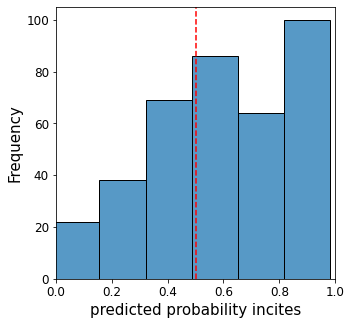

In [4]:
print(len(exem))
f = exem[exem['pred'] == -1]
print("-1 ",len(f))
d = exem[exem['pred'] > 0.50]
print(len(d))
print(len(d)/(len(exem) - len(f)))

fig = plt.figure(figsize=(5,5))
ax = sns.histplot(data = exem,x='pred', bins = 12)
plt.xlabel('predicted probability incites', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlim([0,1])
plt.axvline(x = 0.50, color = "red", ls="--")
plt.show()
fig.savefig('fig_exemplar_incites.png')